# __Back of the Battery Calculator__
---
# __5. Pouch Cells__

#### Copyright © Intercalation Ltd. All rights reserved.

<div>
<img src="images/fig_botb.png" width="800">
</div>




In the fifth episode of our Back of the Battery Calculator series, we're stacking up our electrode layers into a pouch cell format!
Make sure you support Intercalation Station by hitting that ***[subscribe!](https://intercalationstation.substack.com/subscribe)***

---
## BotB Plan
1. Theoretical capacities [[link]](https://intercalationstation.substack.com/p/botb-1-introduction-and-capacity)
2. Active materials [[link]](https://intercalationstation.substack.com/p/botb-2-active-materials-and-electrodes)
3. Cell sandwich layers [[link]](https://intercalationstation.substack.com/p/botb-3-the-cell-stack)
4. Winding a cylindrical cell [[link]](https://intercalationstation.substack.com/p/botb-4-cylindrical-cells)
5. **Stacking a pouch cell**
---

## Outline for BotB 5:
* A) Reusing our electrode coatings
* B) Stacked pouch cell geometry
* C) Total capacity and energy
* D) Cell mass and volume
* E) Putting it all together (*with visualizations!*)
* F) Case study: BYD Blade Battery
---

In [61]:
#Import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#Unit & uncertainty management
from pint import UnitRegistry
unit = UnitRegistry()
from uncertainties import ufloat

#Dictionaries with dot notation
from dotmap import DotMap

#Functions created for assembling electrode structures
from BotB_functions.fn_cellstack import *
from BotB_functions.fn_cellformat import *
from BotB_functions.fn_cellanalysis import *


---
## A) Reusing our electrode sandwich

Following BotB 3 and 4, we can use the same defined cell stack with a double coated cathode, anode, separator, and electrolyte. In the same way we can then visualize the stack layer thicknesses easily using the `plot_thickbreakdown` function.

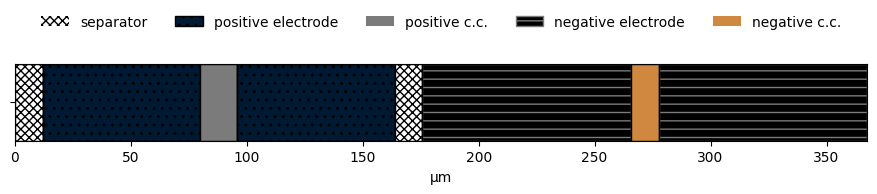

In [62]:
NMC = make_active(name='NMC811',
                 speccap=195*unit.mA*unit.hr/unit.g, 
                 avgE=3.86*unit.V, 
                 density=4.7*unit.g/unit.cm**3,
                 unit=unit)
Gr = make_active(name='Graphite',
                 speccap=344*unit.mA*unit.hr/unit.g, 
                 avgE=0.17*unit.V, 
                 density=2.24*unit.g/unit.cm**3,
                 unit=unit)
pos_composite = make_composite(active=NMC, 
                               arealcap = (4.5*unit.mA*unit.hr/unit.cm**2).plus_minus(0.1), 
                               activefrac = (0.95*unit.dimensionless).plus_minus(0.02),
                               density = (3.4*unit.g/unit.cm**3).plus_minus(0.1),
                               unit=unit)
neg_composite = make_composite(active=Gr, 
                               arealcap = pos_composite.arealcap*1.1, #NP RATIO
                               activefrac = (0.95*unit.dimensionless).plus_minus(0.01),
                               density = (1.6*unit.g/unit.cm**3).plus_minus(0.1),
                               unit=unit)
cc_Al = make_currentcollector(name='Al',
                              thick=16*unit.um,
                              unit=unit)
cc_Cu = make_currentcollector(name='Cu',
                              thick=12*unit.um,
                              unit=unit)
electrolyte = make_electrolyte(name="LiPF6:EC:EMC 3:7",
                        concentration=(1.1*unit.mol/unit.L).plus_minus(0.05),
                        unit=unit)
celgard = make_separator(name="PP:PE",
                           porosity=0.44,
                           thick=12*unit.um,
                           density=0.9*unit.g/unit.cm**3,
                           unit=unit)
pos_electrode = make_electrode(composite=pos_composite,
                               currentcollector=cc_Al,
                               unit=unit)
neg_electrode = make_electrode(composite=neg_composite,
                               currentcollector=cc_Cu,
                               unit=unit)
cellstack = make_cellstack(positive=pos_electrode,
                           negative=neg_electrode,
                           separator=celgard,
                           electrolyte=electrolyte,
                           unit=unit)
# print_struct(cellstack) #Uncomment to see full cell stack parameters
cell = {"cellstack": cellstack}
cell = DotMap(cell)
cell.unit = unit
plot_thickbreakdown(cell)

---
## B) Pouch cell geometry

A stacked pouch cell has multiple electrode sandwich layers stacked on top of each other instead of being wound up. Each layer's current collectors are then welded together to form a single cell. Unlike cylindrical Li-ion cells that tend to fall into standardised geometries, pouch cells can be easily manufactured to any required sizes. On the largest end, pouch cells like the [BYD blade](https://topelectricsuv.com/news/byd/byd-blade-battery-update/#:~:text=The%20BYD%20Blade%20battery%20comes,type%20arrangement%20into%20a%20pack.) battery can reach 90 cm in length!

This [figure](https://www.semanticscholar.org/paper/Three-Dimensional-Thermal-Model-of-a-Lithium-Ion-of-Murashko-Pyrhonen/08180ac24e96f7dde5b6d38ec55a49ee91b93882/figure/0) provides a good schematic of how the layers stack up in the cell:

<div>
<img src="images/botb5_f1.png" width="700">
</div>


We can also look at this [flow chart](https://www.festo.com/tw/en/e/solutions/industry-segments/electronics-industry/battery-manufacturing-id_6949/) for how pouch cells are assembled to get some intuition for what components are involved. We'll just look at stacked versions, although pouch and prismatic cells can also have wound electrodes too. 

<div>
<img src="images/botb5_f2.png" width="900">
</div>

You can also see this video for how individual electrode layers are stacked while the separator is folded in a Z fashion: 
https://www.youtube.com/watch?v=YAedsOH-VXo




## Defining the pouch cell geometry:

Based on the above figures (including our banner image!), we can tell theres a couple extra parameters that we need to include to define the full battery geometry. For our model, we will define the pouch cell height and width, and the thickness will be set by the number of electrode sandwich layers we include in the full cell. Of course, one could also set the thickness and calculate how many layers would fit within those constraints.

Instead of the diameter and mandrel etc sizes used for the cylindrical cell, we have:

* `height` - height of pouch cell
* `width` - width of the pouch cell
* `nlayers` - number of layers of the individual cell sandwich stacks
* `pouchthick` - thickness of the pouch material, usually a polymer-laminated aluminum foil
* `pouchdens` - density of the pouch material
* `pouchclearance` - how much extra pouch material is needed in order to vacuum/heat seal the cell
* `tabh` - tab height
* `tabw` - tab width
* `tabt` - tab thickness
* `tabdenspos` - density of the positive tab (often aluminium)
* `tabdensneg` - density of the negative tab (often nickel for corrosion resistance)
* `tabloc` - where are the tabs going?
* `extramass` - an extra mass factor that is used to account for the tape, seals, and other random components

Lets define some typical values for an automotive pouch cell:

In [63]:
height=22*unit.cm
width=16*unit.cm
nlayers=20

pouchthick = 1*unit.mm
pouchdens = 1.8*unit.g/unit.cm**3
pouchclearance = 0.5*unit.cm

tabh = 2*unit.cm
tabw = 4*unit.cm
tabt = 0.05*unit.cm
tabdenspos = 2.7*unit.g/unit.cm**3
tabdensneg = 8.9*unit.g/unit.cm**3
tabloc = 'top'

extramass=(10*unit.g).plus_minus(10)

So based on these values, we can calculate the total electrode area available in the cell! No funny business with archimedes spirals this time round:

In [64]:
#Calculate the electrode sheet area
area = nlayers*width*height #electrode area

area.ito(unit.cm**2) #convert to cm2
print('electrode area: ')
print(area)

electrode area: 
7040 centimeter ** 2


Understandably, this EV pouch cell has a much higher electrode area compared with our jelly roll calculation for cylindrical cells in BotB4 (~570 cm$^2$).

---
## C) Total capacity and energy

Now that we can work out the exact area and amount of active materials are coated onto the electrodes based on the electrode area, we can go ahead and calculate the total capacity and energy of the battery.

**Capacity**

* Because lithium can be stored in either the positive or negative active material, the actual lithium capacity is given by limiting areal capacity, which is the smaller of the two.

* We then use the above areal capacity along with electrode area to work out the total capacity of the double sided electrode coatings.

* For each battery we can also include a loss of lithium inventory factor `llifactor` which is used to account of any initial decrease in capacity from formation and degradation etc

Indeed, if we perform this calculation and look at the spec sheets for common pouch cells, they also have [similar capacities for this geometry](https://www.alibaba.com/product-detail/5C-Lipo-NCM-Pouch-Cells-3_1600251793576.html).

In [65]:
#Capacity
llifactor = 0.95 # 5% initial capacity loss
capacity = min(cellstack.positive.composite.arealcap,cellstack.negative.composite.arealcap) * llifactor * 2*area #double coat

capacity.ito(unit.A*unit.hr)
print('cell capacity: ')
print(capacity)

cell capacity: 
(60.2 +/- 1.3) ampere * hour


**Energy** 

* The cell energy is given by the average voltage multiplied by the cell capacity

* The average voltage is given by the difference between the positive active material voltage and the negative active material voltage

Carrying this out, we find the cell has an energy of 220 Wh, also within reason to the 60 Ah standard cell!

In [66]:
#Energy
energy = capacity*(cellstack.positive.composite.active.avgE-cellstack.negative.composite.active.avgE)
energy.ito(unit.W*unit.hr)
print('cell energy: ')
print(energy)

cell energy: 
(222 +/- 5) hour * watt


---
## D) Cell mass and volume

Lets calculate the gravimetric and volumetric energy density, which requires us to know the cell mass and volume.

**Cell mass**

* Because we already assigned densities to most components under `cellstack`, we just need the area and thicknesses to work out the mass of each component
* Electrolyte mass is set by the `ecapratio` which is the electrolyte volume to cell capacity ratio (mL/Ah), same as in BotB4
* We also need to calculate the outer can mass which is given by the area and density of the pouch (including excess) and the tab
* Finally, gravimetric energy density is given by dividing `energy` by `cellmass`



In [67]:
#Electrolyte to capacity ratio:
ecapratio = 1.6*unit.mL/(unit.A*unit.hr)

#Total electrolyte mass
elytemass = ecapratio*capacity*cellstack.electrolyte.density
elytemass.ito(unit.g)

#Positive electrode mass: each electrode layer includes 2 layers of composite + 1 layers of current collector
posmass = area*(2*cellstack.positive.composite.thick*cellstack.positive.composite.density) #double coated
posmass.ito(unit.g)
posccmass = area*(cellstack.positive.currentcollector.thick*cellstack.positive.currentcollector.density)
posccmass.ito(unit.g)

#Negative electrode mass: each electrode layer includes 2 layers of composite + 1 layers of current collector
negmass = area*(2*cellstack.negative.composite.thick*cellstack.negative.composite.density) #double coated
negmass.ito(unit.g)
negccmass = area*(cellstack.negative.currentcollector.thick*cellstack.negative.currentcollector.density)
negccmass.ito(unit.g)

#Separator mass: Separator in the cell covers each side of each layer
sepmass = area*(2*cellstack.separator.thick*cellstack.separator.density) #2 sided
sepmass.ito(unit.g)

#Total jelly roll mass
jellymass = posmass + posccmass + negmass + negccmass + sepmass + elytemass
jellymass.ito(unit.g)

#Outer Packaging Pouch Mass
pouchmass = pouchdens*pouchthick*(width+pouchclearance)*(height+pouchclearance)*2 #2 layer pouch sealed together

#Tab mass
tabmass = (tabh+pouchclearance)*tabw*tabt*tabdenspos + (tabh+pouchclearance)*tabw*tabt*tabdensneg

#Overall packaging mass
casemass = pouchmass + tabmass + extramass
casemass.ito(unit.g)

#Total cell mass (jelly roll + case mass)
cellmass = casemass + jellymass
cellmass.ito(unit.g)
gravimetric_energy_density = energy/cellmass
gravimetric_energy_density.ito(unit.W * unit.hr /unit.kg)
print('cell gravimetric energy density: ')
print(gravimetric_energy_density)

cell gravimetric energy density: 
(243 +/- 9) hour * watt / kilogram


**Cell volume**

For cell volume, we need the stack thickness of each layer, multiplied by the total layers along with the overall pouch width and height.

Remember we also need to include the thicknesses of the pouch material!


In [68]:
#Cell volume
#Stackthick
stackthick = 2*cellstack.positive.composite.thick + cellstack.positive.currentcollector.thick  \
                + 2*cellstack.negative.composite.thick + cellstack.negative.currentcollector.thick  \
                    + 2*cellstack.separator.thick
stackthick.ito(unit.cm)

#Cell volume
depth = nlayers*stackthick + 2*pouchthick
pouchvol = (width + pouchclearance) * (height + pouchclearance) *  depth
tabvol = (tabh+pouchclearance)*tabw*tabt*2
volume = pouchvol + tabvol
volume.ito(unit.cm**3)
volumetric_energy_density = energy/volume
volumetric_energy_density.ito(unit.W * unit.hr /unit.L)
print('cell volumetric energy density: ')
print(volumetric_energy_density)

cell volumetric energy density: 
(638 +/- 24) hour * watt / liter


---
## E) Putting it all together (*with visualizations!*)

Based on all the above calculations, we can now take all the bottom up properties and calculate the energy densities of a pouch cell.

For BotB 5 we've put all these calculations together in the `make_pouch()` function. We put all the parameters for cell geometry, cell stack, electrolyte ratio, and extra factors like lithium loss and extra mass together into a structure.

Here's how we would call `make_pouch()`, you can look at the nitty gritty details under the `fn_cellformat.py` file attached to this BotB sheet. 
This function calculates the jelly roll area, component masses, volume, as well as the cell design parameter NP-ratio, which is the ratio between negative and positive active material capacities.

Once the `cell` structure is created, you can also use the `print_cellresults()` function to print a tidy summary of the cell specs:

In [69]:
cell = make_pouch(name='Pouch cell',
                  cellstack=cellstack,
                  ecapratio=(1.6*unit.mL/(unit.A*unit.hr)),
                  
                  height=22*unit.cm,
                  width=16*unit.cm,
                  nlayers=20,
                  
                  pouchthick = 1*unit.mm,
                  pouchdens = 1.8*unit.g/unit.cm**3,
                  pouchclearance = 0.5*unit.cm,
                  
                  tabh = 2*unit.cm,
                  tabw = 4*unit.cm,
                  tabt = 0.05*unit.cm,
                  tabdenspos = 2.7*unit.g/unit.cm**3,
                  tabdensneg = 8.9*unit.g/unit.cm**3,
                  tabloc = 'top',
                  
                  llifactor=0.95,
                  extramass=(10*unit.g).plus_minus(10),
                  unit=unit)

print_cellresults(cell)

Pouch cell   (pouch stacked)
Al | NMC811 | PP:PE | LiPF6:EC:EMC 3:7 | Graphite | Cu
grav. energy dens.:(243 +/- 9) hour * watt / kilogram
vol energy dens.:(638 +/- 24) hour * watt / liter
------------------------------------------------------------
Avg. cell voltage: 3.69 volt
cell energy: (222 +/- 5) hour * watt
cell capacity: (60.2 +/- 1.3) ampere * hour
cell mass: 914+/-28 gram
np ratio: 1.1


### Visualizing the geometry

We also made some functions you can call to better visualize the pouch cell geometry

* `plot_3D_pouch()` shows a 3D render of the cylindrical cell with labelled geometries:

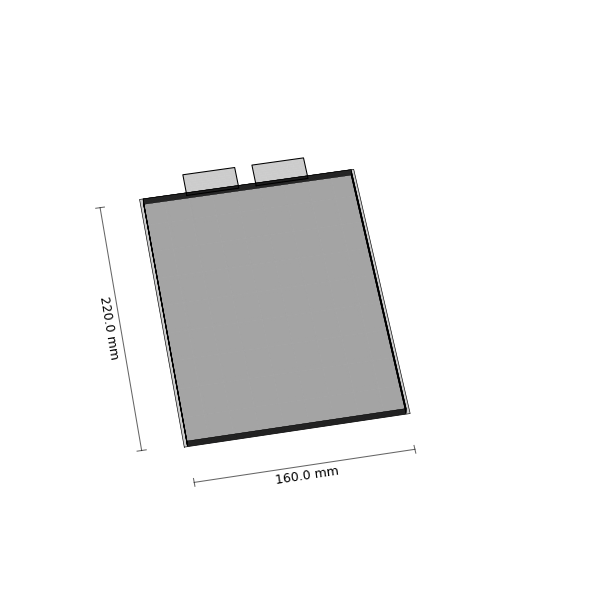

In [70]:
# %matplotlib widget #Uncomment if you have interactive matplotlib enabled
plot_3D_pouch(cell)

### Visualizing the mass and thickness breakdown

We've shown the `plot_thickbreakdown()` before for the cellstack, it also works for full cells

* `plot_massbreakdown()` shows the mass proportions for the components in the cell, including the outer casing

Lets do it for the pouch cell here:

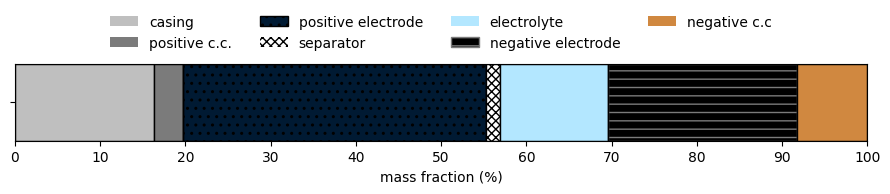

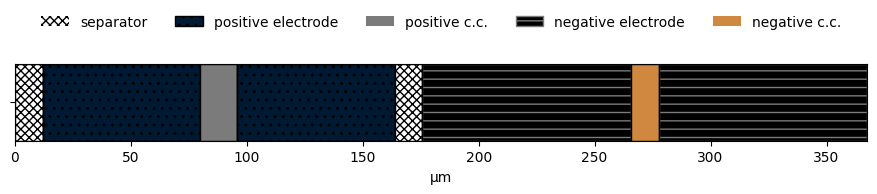

In [71]:
# %matplotlib inline
plot_massbreakdown(cell)
plot_thickbreakdown(cell)

---
## G) Quick example: BYD Blade Battery



Matt Lacey tweeted a thread revealing that the often quoted volumetric energy density numbers for BYD's blade battery is probably overstated. This has some genuine repercussions, as these figures have been cited in [influential studies](https://www.nature.com/articles/s41560-020-00757-7) that shapes our perception of LFP cathode cells. 


<blockquote class="twitter-tweet"><p lang="en" dir="ltr">There&#39;s an interesting discussion in this nice new video from <a href="https://twitter.com/LimitingThe?ref_src=twsrc%5Etfw">@LimitingThe</a> on an apparent gap between BYD&#39;s reported Wh/L for the Blade pack and what it likely is. There&#39;s probably some lessons here about not trusting everything you find on the internet... 1/ <a href="https://t.co/9Cjy0OJVLe">https://t.co/9Cjy0OJVLe</a> <a href="https://t.co/r51alWrFrN">pic.twitter.com/r51alWrFrN</a></p>&mdash; Matt Lacey (@mjlacey) <a href="https://twitter.com/mjlacey/status/1479407878171770882?ref_src=twsrc%5Etfw">January 7, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

The widely shared specs for the BYD blade cell can be found [online on several EV blogs:](https://topelectricsuv.com/news/byd/byd-blade-battery-update/)

<div>
<img src="images/botb5_f3.png" width="500">
</div>

However, Matt's analysis shows that the volumetric energy density is probably closer to 355 Wh/L, rather than 450 Wh/L. This is 20% less! 

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">But let&#39;s just say that 165 Wh/kg is reasonable (that sits in the same range as the other comparable cells) and the density is more likely ~2.15 g/cm³. This gives a cell level energy density of 355 Wh/L. And if we say CTP ratio is 62.4% as reported -&gt; 221 Wh/L on pack level. 11/</p>&mdash; Matt Lacey (@mjlacey) <a href="https://twitter.com/mjlacey/status/1479407913416466432?ref_src=twsrc%5Etfw">January 7, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

While the BYD blade battery is a prismatic cell, the rough geometry is similar to that of a pouch cell.

---
## **Lets use our BotB model to generate an LFP cell with the same BYD Blade geometry, to see how the numbers match up!**


**1. First, lets replace our NMC electrode stack with LFP:**

In [72]:
# Replacing positive electrode with LFP:
LFP = make_active(name='LFP',
                 speccap=160*unit.mA*unit.hr/unit.g, 
                 avgE=3.375*unit.V, 
                 density=3.6*unit.g/unit.cm**3,
                 unit=unit)

pos_composite = make_composite(active=LFP, 
                               arealcap = (3.2*unit.mA*unit.hr/unit.cm**2).plus_minus(0.1), 
                               activefrac = (0.95*unit.dimensionless).plus_minus(0.02),
                               density = (3.5*unit.g/unit.cm**3).plus_minus(0.1),
                               unit=unit)

pos_electrode = make_electrode(composite=pos_composite,
                               currentcollector=cc_Al,
                               unit=unit)

neg_composite = make_composite(active=Gr, 
                               arealcap = pos_composite.arealcap*1.1, #NP RATIO
                               activefrac = (0.95*unit.dimensionless).plus_minus(0.01),
                               density = (1.6*unit.g/unit.cm**3).plus_minus(0.1),
                               unit=unit)
neg_electrode = make_electrode(composite=neg_composite,
                               currentcollector=cc_Cu,
                               unit=unit)

cellstack = make_cellstack(positive=pos_electrode,
                           negative=neg_electrode,
                           separator=celgard,
                           electrolyte=electrolyte,
                           unit=unit)



**2. Next, we build a cell that is 13x90x1.3cm:**

BYD Blade Pouch Geometry   (pouch stacked)
Al | LFP | PP:PE | LiPF6:EC:EMC 3:7 | Graphite | Cu
grav. energy dens.:(158 +/- 6) hour * watt / kilogram
vol energy dens.:(380 +/- 15) hour * watt / liter
------------------------------------------------------------
Avg. cell voltage: 3.205 volt
cell energy: (648 +/- 20) hour * watt
cell capacity: (202 +/- 6) ampere * hour
cell mass: (4.09+/-0.11)e+03 gram
np ratio: 1.1


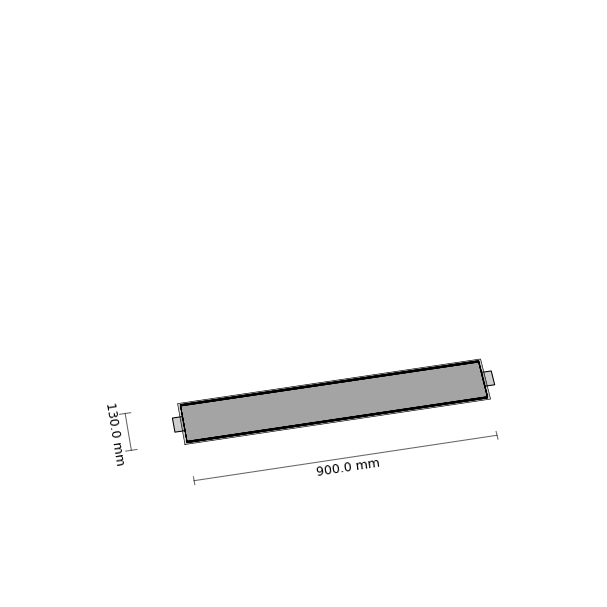

In [73]:
# Building the pouch cell
cell = make_pouch(name='BYD Blade Pouch Geometry',
                  cellstack=cellstack,
                  ecapratio=(1.6*unit.mL/(unit.A*unit.hr)),
                  
                  height=13*unit.cm,
                  width=90*unit.cm,
                  nlayers=30,
                  
                  pouchthick = 2*unit.mm,
                  pouchdens = 1.8*unit.g/unit.cm**3,
                  pouchclearance = 1.5*unit.cm,
                  
                  tabh = 3*unit.cm,
                  tabw = 5*unit.cm,
                  tabt = 0.05*unit.cm,
                  tabdenspos = 2.7*unit.g/unit.cm**3,
                  tabdensneg = 8.9*unit.g/unit.cm**3,
                  tabloc = 'sides',
                  
                  llifactor=0.9,
                  extramass=(10*unit.g).plus_minus(10),
                  unit=unit)

print_cellresults(cell)
plot_3D_pouch(cell)

## Looks like we get some reasonable numbers that support Matt's conclusion!

**Our data vs online reports:** *noting that this was for a pouch not prismatic format*

* Volumetric energy density: 385 Wh/L vs 450 Wh/L (Matt: 355 Wh/L)
* Gravimetric energy density: 160 Wh/L vs 165 Wh/L
* Cell capacity: 208 Ah vs 202 Ah
* Weight: 4.2 kg vs 3.9 kg




---
# Conclusion

* Congrats! We've successfully assembled full pouch cell together, and also used it to explore and fact check new cell geometries.

**Please consider supporting Intercalation and BotB with a subscription. We'll work through some interesting case studies in the near future!**
***[Subscribe Now!](https://intercalationstation.substack.com/publish/post/%%checkout_url%%)***


